In [1]:
%matplotlib ipympl

In [2]:
import cv2
import numpy as np
from scipy.spatial.transform import Rotation as R
from modules.mask_utils import Masker
import bpy
import mathutils
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter, FuncAnimation

In [3]:
import sys
import os

sys.path.append(
    os.path.join(
        os.path.dirname(os.path.abspath('__file__')),
        os.pardir,
        os.pardir,
        )
    )


In [4]:
from backend.core.modules.data_objects import CameraData, VideoData, HumanPose, Body, ContactPoints
from backend.core.modules.plot_utils import coords_converter
from backend.core.modules.cam_utils import get_extrinsic_matrix
from backend.core.modules.body_keypoints import get_edge_coords_all

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 3D Model

Camera Matrix

In [5]:
cam_json = {
    "fx": 1353.6915950245486,
    "fy": 1357.5577115711324,
    "cx": 538.9620188123179,
    "cy": 961.5329984766928,
    "dist_coeffs": [
        0.045870044322073686,
        -0.39564683084494173,
        -0.0020515588805692024,
        0.0015103837799576112,
        1.0718061310340865
    ]
}

In [6]:
cameradata = CameraData(cam_json)

Redndering Camera Orientation

In [7]:
def polar2cartesian_xz(r, theta):
    """
    Get camera cartesian coordinates (only on X-Z plane) fropm ploar representation
    r: distance from the global origin [m]
    theta: angle [deg]. +z to +x axis is +theta.
    """
    theta = np.deg2rad(theta)
    x = r * np.sin(theta)
    z = r * np.cos(theta)
    return x, z

In [8]:
def cam_position2tvec(r, theta, height, vector_fmt=False):
    """
    Obtain cartesian position vector from the cylindical coordinates to 
    """
    x, z = polar2cartesian_xz(r, theta)
    y = height
    if vector_fmt:
        return np.array([[x], [y], [z]])
    else:
        return x, y, z


In [9]:
def cam_position2rvec(theta):
    return np.array([
        [np.deg2rad(0)],
        [np.deg2rad(theta)], 
        [np.deg2rad(0)]
    ])

In [10]:
def add_camera_vec(cam, tvec: np.ndarray, rvec: np.ndarray, name: str):
    """
    cam: bpy.data.cameras
    tvec: translation vector
    rvec: rotation vector
    """
    cam_obj = bpy.data.objects.new(name, cam)
    cam_obj.location = (tvec[0][0], tvec[1][0], tvec[2][0])
    cam_obj.rotation_mode = 'XYZ'
    r = R.from_rotvec([rvec[0][0], rvec[1][0], rvec[2][0]])
    cam_obj.rotation_euler = r.as_euler('xyz', degrees=False)
    return cam_obj

In [11]:
def add_camera(cam, r: float, theta: float, height: float, name: str):
    """
    cam: bpy.data.cameras
    r: Distance from the wall
    theta: Angle of the camera measured from the centre line
    height: Height of the camera
    """
    cam_obj = bpy.data.objects.new(name, cam)
    x, y, z = cam_position2tvec(r, theta, height)
    cam_obj.location = (x, y, z)
    cam_obj.rotation_mode = 'XYZ'
    cam_obj.rotation_euler = (np.deg2rad(0), np.deg2rad(theta), np.deg2rad(0))
    return cam_obj

Bleander camera object

In [12]:
def create_camera(f_in_mm, scene):
    """
    scene: blender scene
    Returns: bpy.data.cameras
    """
    cam = bpy.data.cameras.new('Camera')
    cam.lens = f_in_mm
    sensor_w_in_mm = cam.sensor_width
    res_x = scene.render.resolution_x
    res_y = scene.render.resolution_y
    scale = scene.render.resolution_percentage / 100.0
    aspect_ratio = scene.render.pixel_aspect_y / scene.render.pixel_aspect_x
    # Get pixel size
    resolution_x_in_px = res_x * scale
    resolution_y_in_px = res_y * scale
    # Focal length in pixels
    fx = f_in_mm / sensor_w_in_mm * resolution_x_in_px
    fy = fx / aspect_ratio
    # Principal point
    cx = resolution_x_in_px / 2 - cam.shift_x * resolution_x_in_px
    cy = resolution_y_in_px / 2 + cam.shift_y * resolution_y_in_px
    # Construct K
    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])
    return cam, K

Rendering

In [13]:
def render(camera, save_to):
    """
    camera: camera object
    """
    # Render from cam0
    scn.camera = camera
    bpy.ops.render.render(write_still=True)
    bpy.data.images["Render Result"].save_render(filepath=save_to)


Blender Creating the Scene

In [14]:
# Deselect all
bpy.ops.object.select_all(action='SELECT')
bpy.ops.object.delete(use_global=False)

# Create and activate scene
new_scene = bpy.data.scenes.new("EmptyScene")
bpy.context.window.scene = new_scene
scn = new_scene
scn.unit_settings.system = 'METRIC'
scn.unit_settings.scale_length = 1.0

Load the 3D mesh model

In [15]:
file_path = 'C:/Users/susum/Desktop/MB2024.blend'
with bpy.data.libraries.load(file_path, link=False, relative=True) as (data_from, data_to):
    # data_from: data blocks available to link/append
    # data_to: data blocks I want to load
    data_to.objects = ['Mesh_0_Part_0']

for obj in data_to.objects:
    if obj is not None:
        scn.collection.objects.link(obj)

In [16]:
# Create a point light
light_data = bpy.data.lights.new(name='dataLight', type='POINT')
light_data.energy = 800
# Create a light object
light = bpy.data.objects.new(name='Light', object_data=light_data)
x, z = polar2cartesian_xz(7, 0)
y = 2
light.location = (x, y, z)
scn.collection.objects.link(light)

Creating Rendering Cameras

In [17]:
# f_in_mm = (camera_json['fx'] + camera_json['fy']) / 2
f_in_mm = 35
cam, K_blender = create_camera(f_in_mm, scn)
cam_obj0 = add_camera(cam, 8, 0, 1.7, 'pov0')
render(cam_obj0, 'C:/Users/susum/Desktop/MB2024_render0.png')
cam_obj1 = add_camera(cam, 8, 30, 1.7, 'pov1')
render(cam_obj1, 'C:/Users/susum/Desktop/MB2024_render1.png')
cam_obj2 = add_camera(cam, 8, -30, 1.7, 'pov2')
render(cam_obj2, 'C:/Users/susum/Desktop/MB2024_render2.png')

In [18]:
img1 = cv2.imread('C:/Users/susum/Desktop/MB2024_render0.png')
# img1 = cv2.imread('C:/Users/susum/Desktop/MB2024_render1.png')
# img1 = cv2.imread('C:/Users/susum/Desktop/MB2024_render2.png')

Loading the video frame

In [19]:
videodata = VideoData("C:/Users/susum/Desktop/1StarChoss_trimmed.mp4")

In [20]:
videodata_copy = VideoData("C:/Users/susum/Desktop/1StarChoss_trimmed.mp4")
human_pose = videodata_copy.get_human_pose()
del videodata_copy

HumanPose initialised


In [21]:
frame_number = 50

In [22]:
# img2 = cv2.imread('C:/Users/susum/Desktop/MB2024_record1.png')
# img2 = cv2.imread('C:/Users/susum/Desktop/MB2024_record2.png')
# img2 = cv2.imread('C:/Users/susum/Desktop/MB2024_record3.png')
# img2 = cv2.imread('C:/Users/susum/Desktop/MB2024_record4.png')
# img2 = cv2.imread('C:/Users/susum/Desktop/MB2024_record5.png')
img2 = cv2.undistort(videodata.load_frame(frame_number), cameradata.intrinsic_matrix, cameradata.distortion_coeff)

Image Preparation

In [23]:
def gammaCorrection(src):
    #  ratio of the log(mid)/log(mean)
    mid = 0.3
    mean = np.mean(src)
    gamma = np.log(mid * 255) / np.log(mean)

    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

In [24]:
def invert(src):
    """
    Inverted grey image
    """
    return cv2.bitwise_not(src)

In [25]:
# Colour -> Grey

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [26]:
# Blurred Grey Images

# img1_gray = cv2.GaussianBlur(img1_gray, (3,3), cv2.BORDER_DEFAULT)
img2_gray = cv2.GaussianBlur(img2_gray, (3,3), cv2.BORDER_DEFAULT)

In [27]:
# Gamma Correction

# img1_adjust = img1_gray
# img1_adjust = cv2.equalizeHist(img1_gray)
img1_adjust = gammaCorrection(img1_gray)
# img1_adjust = cv2.Canny(img1_adjust, 20, 20)


# img2_adjust = img2_gray
# img2_adjust = cv2.equalizeHist(img2_gray)
img2_adjust = gammaCorrection(img2_gray)
# img2_adjust = cv2.Canny(img2_adjust, 20, 20)

In [28]:
# Invert the Grey 

img1_ = invert(img1_adjust)
img2_ = invert(img2_adjust)

Matching Point Detection

In [29]:
# Maks the non-wall area out of the interest for the feature point detection
yolomodel = 'models/best.pt'
masker = Masker(yolomodel)
mask_segment = masker.apply_mask(img2, 0.3, cls2include=[0], cls2exclude=[1, 2])


0: 640x384 1 wall, 2 kickerboards, 1 climber, 96.1ms
Speed: 3.9ms preprocess, 96.1ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 384)


In [30]:
# A-KAZE detector
akaze = cv2.AKAZE_create()
# Initiate ORB detector
# akaze = cv2.ORB_create()

# Feature detection and feature vector computation
# https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677
kp1, des1 = akaze.detectAndCompute(img1_, None)
kp2, des2 = akaze.detectAndCompute(img2_, mask_segment)

In [31]:
cross_check = True
# cross_check = False

# creating Brute-Force Matcher
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
if cross_check:
    bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)
    matches = bf.match(des1, des2)
    # Sort them in the order of their distance.
    matches_good = sorted(matches, key = lambda x:x.distance)
else:
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    # Select pairs by similarity in feature vectors
    matches_good = []
    ratio = 0.5
    while len(matches_good) < 20:
        ratio += 0.01
        matches_good = []
        for m, n in matches:
            if m.distance < ratio * n.distance:
                matches_good.append([m])

In [32]:
# Geometric Verification -> Assuming that the feature points are alighned on the same plane!
# queryIdx: index of the descriptor in the first set
# trainIdx: index of the descriptor in the second set

# Rendered image
pt1 = np.float32([kp1[m.queryIdx].pt for m in matches_good])
# Snapshot
pt2 = np.float32([kp2[m.trainIdx].pt for m in matches_good])


In [33]:
# Compute homography using RANSAC
# https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
# https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html
perspective_transformation, mask = cv2.findHomography(pt1, pt2, cv2.RANSAC, 5.0)

matches_plane = []
for i, m in enumerate(matches_good):
    if mask[i]:
        matches_plane.append(m)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches_plane, None, flags=2)
cv2.imwrite('C:/Users/susum/Desktop/MB2024_matching.png', img3)

True

[]

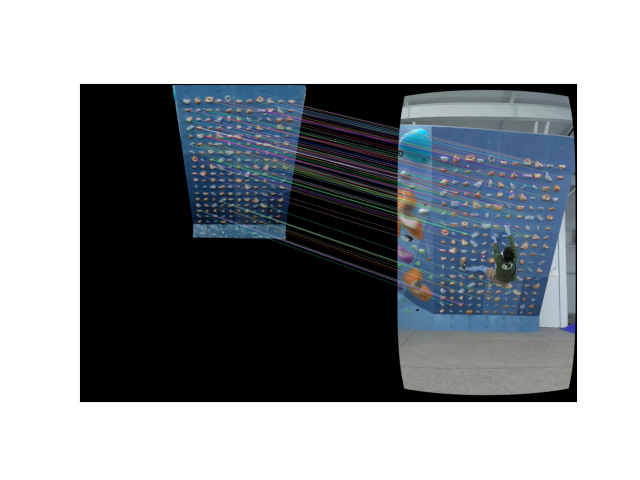

In [34]:
fig, ax = plt.subplots()
ax.imshow(img3)
ax.set_xticks([])
ax.set_yticks([])

In [35]:
len(matches_plane)/len(matches_good)

0.34210526315789475

Find 3D Coordinates of the Matching Points on the 3D Mesh Model

In [36]:
def pixel_to_world_ray(x, y, cam_obj, cam_intrinsics, render_size):
    """
    Calculate the ray vector in the camera direction originated from a point on the rendered image
    """
    fx = cam_intrinsics[0,0]
    fy = cam_intrinsics[1,1]
    cx = cam_intrinsics[0,2]
    cy = cam_intrinsics[1,2]
    # fx, fy, cx, cy = cam_intrinsics["fx"], cam_intrinsics["fy"], cam_intrinsics["cx"], cam_intrinsics["cy"]
    width, height = render_size

    # Convert to normalized device coords
    x_ndc = (x - cx) / fx
    y_ndc = (y - cy) / fy
    ray_camera = mathutils.Vector((x_ndc, -y_ndc, -1)).normalized()  # Blender uses -Z forward
    # ray_camera = mathutils.Vector((x_ndc, y_ndc, 1)).normalized()

    # Transform ray to world coordinates
    ray_world = cam_obj.matrix_world.to_3x3() @ ray_camera
    origin_world = cam_obj.matrix_world.to_translation()

    return origin_world, ray_world.normalized()

In [37]:
def intersect_ray_with_mesh(scene, origin, direction):
    """
    Coordinates of intersection with the rays from the feature points and the 3d mesh
    """
    depsgraph = bpy.context.evaluated_depsgraph_get()
    result, location, normal, index, obj, matrix = scene.ray_cast(
        depsgraph, origin, direction
    )
    return location if result else None


In [38]:
# Coordinates of the keypoints in reference and target images
pt1 = np.float32([kp1[m.queryIdx].pt for m in matches_plane])
pt2 = np.float32([kp2[m.trainIdx].pt for m in matches_plane])

Compute the mesh & ray intersection points

In [39]:
def get_depth_ray_casting(coords2d, scene, cam_obj, K_blender):
    """
    coords2d: [[x, y], ...]
    scene: blender scene
    cam_obj: blender camera object
    K_blender: blender camera intrinsic matrix
    """
    render_size = (scene.render.resolution_x, scene.render.resolution_y)

    coords3d = []
    for pt in coords2d:
        origin, direction = pixel_to_world_ray(pt[0], pt[1], cam_obj, K_blender, render_size)
        intersection = intersect_ray_with_mesh(scene, origin, direction)
        if intersection is not None:
            coords3d.append(intersection)
        else:
            coords3d.append(None)  # No hit
    return coords3d


In [40]:
def get_pair_2d_3d(pt_render, pt_videoframe, scene, cam_obj, K_blender):
    """
    Get 2d and 3d coordinates identified from the feature matching
    pt_render: 2d coordinates array from the mesh model. result of the feature mathcing
    pt_videoframe: 2d coordinates array from the video frame snapshot.
    """
    pt_ray_casting = get_depth_ray_casting(pt_render, scene, cam_obj, K_blender)
    pts_wld = []
    pts_img = []
    for coords_w, coords_i in zip(pt_ray_casting, pt_videoframe):
        if coords_w is not None:
            pts_wld.append([coords_w[0], coords_w[1], coords_w[2]])
            pts_img.append([coords_i[0], coords_i[1]])

    # blender coords -> opencv coords
    # pts_wld = np.array([coords_converter(coords, 'blender-opencv') for coords in pts_wld])
    pts_wld = np.array([coords_converter(coords, 'blender-matplotlib') for coords in pts_wld])
    pts_img = np.array(pts_img)
    return pts_img, pts_wld

In [41]:
pts_img, pts_wld = get_pair_2d_3d(pt1, pt2, scn, cam_obj0, K_blender)

Visualise the 3D Coords of the feature points

Text(0.5, 0, 'Z')

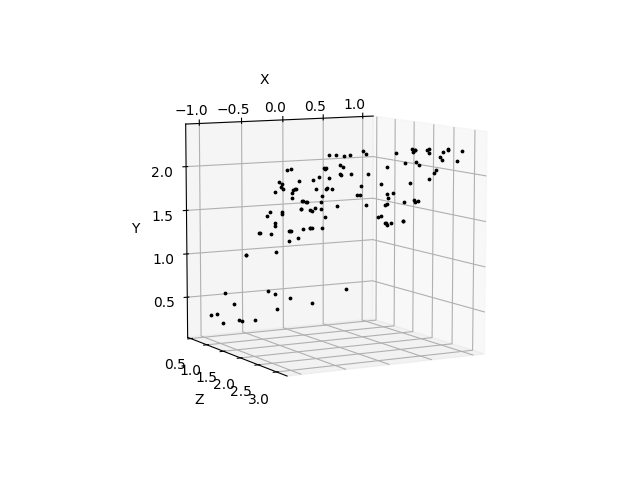

In [42]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect('equal')
for coords in pts_wld:
    x, y, z = coords
    ax.scatter(x, y, z, c='black', s=3)
ax.view_init(elev=60, azim=164, roll=-104)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Computing the rotation & translation vectors for the 3D corrds to the 2D coords projection

In [43]:
def solvePnP(world_coords, img_coords, cameradata:CameraData, **kwargs):
    """
    PnP solver for the wall and human pose
    """
    vervose = kwargs.pop('vervose', False)
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        world_coords,
        img_coords,
        cameradata.intrinsic_matrix,
        np.array(cam_json['dist_coeffs']),
        flags=cv2.SOLVEPNP_ITERATIVE,
        reprojectionError=8.0,
        confidence=0.99
    )

    if success:
        if vervose:
            print("Rotation Vector:\n", rvec)
            print("Translation Vector:\n", tvec)
        return rvec, tvec
    else:
        print("PnP RANSAC failed.")
        return None, None

In [44]:
rvec_wall, tvec_wall = solvePnP(pts_wld, pts_img, cameradata)
rvec_wall, tvec_wall

(array([[     2.7978],
        [   0.055933],
        [    0.13818]]),
 array([[  -0.077803],
        [     1.8336],
        [     5.7268]]))

In [45]:
# # f_in_mm = (cam_json['fx'] + cam_json['fy']) / 2
# f_in_mm = 35
# cam_obs, K_blender = create_camera(f_in_mm, scn)
# cam_obj = add_camera_vec(cam_obs, tvec_wall, rvec_wall, 'pov')
# render(cam_obj, 'C:/Users/susum/Desktop/MB2024_render.png')

In [46]:
r, theta, height = 8, 0, 1.7
rvec_render = cam_position2rvec(theta)
tvec_render = cam_position2tvec(r, theta, height, vector_fmt=True)
T_wall_rendering = get_extrinsic_matrix(rvec_render, tvec_render)
T_wall_rendering_inv = np.linalg.inv(T_wall_rendering)

In [47]:
T_wall = get_extrinsic_matrix(rvec_wall, tvec_wall)
T_wall_inv = np.linalg.inv(T_wall)

# Later work ...
 !Theoretical configuration of holds. Need to kow the exact rvec and tvec to the rendered image in blender to make it work!

In [48]:
# import pickle
# import os
# class Holds:
#     """
#     Get coordinates of all the holds projected to the video frame from the rotayion & translation matrix and the 3d coordinates of the holds
#     coords_world: 3d coordinates of all the holds used for solving PnP
#     rvec: Rotation vector
#     tvec: Translation vector
#     camera: CameraData instance
#     """
#     def __init__(self, **kwargs):
#         # wold coordinates of the holds
#         self.path_coords_holds = os.path.join('C:/Users/susum/Desktop', 'world_coords_holds.pkl')
#         self.cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
#         self.col_colours = ['brown', 'red', 'moccasin', 'orange', 'yellow', 'green', 'darkcyan', 'blue', 'blueviolet', 'purple', 'pink']
#         self.colour_dict = {k: c for k, c in zip(self.cols, self.col_colours)}

#         if not os.path.exists(self.path_coords_holds):
#             self.init_nodes(**kwargs)
#         else:
#             self.coords_world = pickle.load(open(self.path_coords_holds, 'rb'))
#         self.rvec = kwargs.pop('rvec', None)
#         self.tvec = kwargs.pop('tvec', None)
#         self.camera = kwargs.pop('camera', None)  # CameraData instance
#         self.K = self.camera.intrinsic_matrix
#         self.dist = self.camera.distortion_coeff

#     def init_nodes(self, **kwargs):
#         """
#         Inititialise the node attributes
#         """
#         self.coords_world = {}
#         inverty = kwargs.pop('inverty', False)
#         self.wall_angle = 40 # degrees
#         theta = self.wall_angle / 180 * np.pi

#         y0 = 100 * np.cos(theta) + 370
#         z0 = 100 * np.sin(theta)
#         for col in self.cols:
#             for row in range(1,19):
#                 # Centred on column F
#                 xx = (self.cols.index(col) - 5) * 200
#                 yy = y0 + 200 * np.cos(theta) * (row - 1)
#                 # zz = z0 + 200 * np.sin(theta) * (row - 1)
#                 zz = -(z0 + 200 * np.sin(theta) * (row - 1))
#                 if inverty:
#                     yy = -1 * yy
#                 # self.coords_world[col + str(row)] = (xx, yy, zz)
#                 self.coords_world[col + str(row)] = (xx*1e-3, yy*1e-3, zz*1e-3)  # mm to m

#         pickle.dump(self.coords_world, open(self.path_coords_holds, 'wb'))

#     def get_projection(self):
#         """
#         Get the projection of the holds world coordinates to the video perspective
#         """
#         # Map the 3D point to 2D point
#         world_coords = np.array(list(self.coords_world.values())).astype('float32')
#         coords_2d, _ = cv2.projectPoints(world_coords, 
#                                         self.rvec, self.tvec, 
#                                         self.K, 
#                                         self.dist)
#         self.coords_frame = {k: v for k, v in zip(self.coords_world.keys(), coords_2d)}
#         return self.coords_frame


In [49]:
# kwargs = {
#     'inverty': True,
#     'rvec': rvec_wall,
#     'tvec': tvec_wall, 
#     'camera': cameradata,
# }
# holds = Holds(**kwargs)

In [50]:
# fig, ax = plt.subplots()
# # ax.imshow(img2)
# ax.set_aspect('equal')
# for k, v in holds.coords_world.items():
#     xx, yy, zz, _ = T_wall @ T_wall_rendering @ [v[0], v[1], v[2], 1]
#     # xxx, yyy, zzz, _ = T_wall_inv @ [xx, yy, zz, 1]
#     # ax.scatter(xxx, yyy, zzz, label=k, s=1)
#     ax.scatter(xx, yy, label=k, s=1, c=holds.colour_dict[k[0]])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')

# Human Pose Estimation

#  Repeat the Analysis for Each Frames of the submitted video

- Get the initial guess of the rendering angle
- Sample parameters -> Maximise the number of matching points
- Get the full tvec and rvec from the mesh model to the scene
- Get the 3D human pose coordinates adjusteds

SolvePnP for 3D and 2D human pose pair

In [51]:
def mediapipe_3d2d_solvePnP(humanpose: HumanPose, t: int):
    """
    Obtain Mediappipe 3d pose -> 2d pose projection tvec & tvec at frame t
    """
    rvec, tvec = solvePnP(humanpose.coords3d[t], humanpose.coords2d[t], cameradata)
    return rvec, tvec

In [52]:
rvec_mp2img, tvec_mp2img = mediapipe_3d2d_solvePnP(human_pose, frame_number)

In [53]:
T_mp2img = get_extrinsic_matrix(rvec_mp2img, tvec_mp2img)

[]

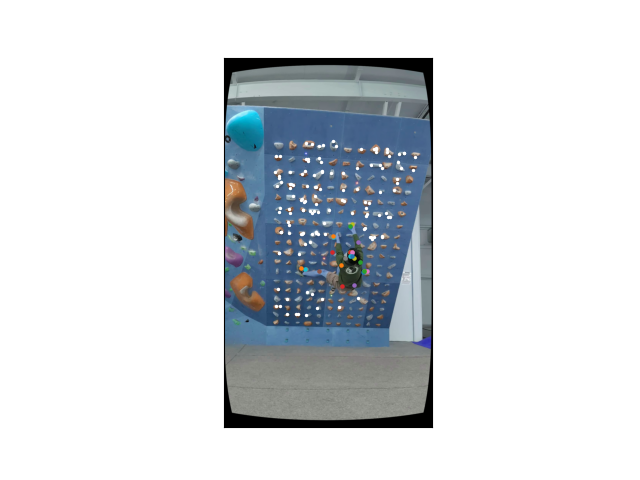

In [54]:
pose2d_projection, _ = cv2.projectPoints(
    human_pose.coords3d[frame_number],
    rvec_mp2img, tvec_mp2img,
    cameradata.intrinsic_matrix,
    np.array(cameradata.distortion_coeff)
    )

holds2d_projection, _ = cv2.projectPoints(
    pts_wld,
    rvec_wall, tvec_wall,
    cameradata.intrinsic_matrix,
    np.array(cameradata.distortion_coeff)
    )

fig, ax = plt.subplots()
ax.imshow(img2)
for i in range(pose2d_projection.shape[0]):
    ax.scatter(*pose2d_projection[i][0], s=5)

for i in range(holds2d_projection.shape[0]):
    ax.scatter(*holds2d_projection[i][0], c='white', s=2)

ax.set_xticks([])
ax.set_yticks([])


In [55]:
def coords_transformation(coords3d, *args):
    pose_global = []
    for kp in coords3d:
        xx, yy, zz = kp
        for M in args:
            xx, yy, zz, _ = M @ [xx, yy, zz, 1]
        # xx, yy, zz, _ = T_wall_inv @ T_mp2img @ [kp[0], kp[1], kp[2], 1]
        # xx, yy, zz, _ = T_mp2img @ [kp[0], kp[1], kp[2], 1]
        pose_global.append([xx, yy, zz])
    return np.array(pose_global)

In [56]:
pose_global = coords_transformation(human_pose.coords3d[frame_number], T_mp2img, T_wall_inv)

Text(0.5, 0, 'Z')

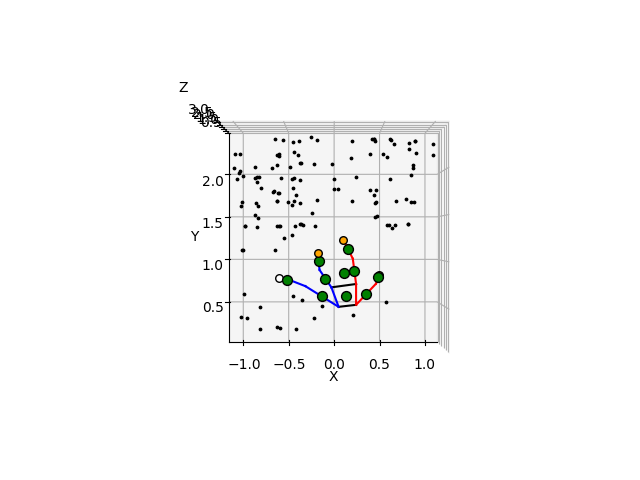

In [57]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect('equal')
# for kp in pose_global:
#     ax.scatter(*kp, c='blue', s= 2)

body = Body(frame_number, human_pose.coords2d[frame_number], pose_global, "C:/Users/susum/Desktop/1StarChoss_trimmed.pkl")
body.plot(ax)

for coords in pts_wld:
    x, y, z = coords
    ax.scatter(x, y, z, c='black', s=3)

# for k, v in get_edge_coords_all(pose_global).items():
#     p0, p1 = v
#     ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], c='red')

# for k, v in holds.coords_world.items():
#     xx, yy, zz, _ = T_wall_rendering @ [v[0], v[1], v[2], 1]
#     ax.scatter(xx, yy, zz, label=k, s=1, c=holds.colour_dict[k[0]])

# ax.view_init(elev=60, azim=164, roll=-104)
# ax.view_init(elev=0, azim=180, roll=-90)
# ax.view_init(elev=0, azim=0, roll=90)
ax.view_init(elev=90, azim=-90, roll=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot_3d(
#     plane.plotter(alpha=0.2, lims_x=(-300, 300), lims_y=(-300, 300)),
# )

Get contact info and adjust the coorddinates

In [58]:
contacts2d = body.contact_points2d
contacts3d = body.contact_points3d

In [59]:
perspective_transformation

array([[     1.2236,    -0.14951,     -482.12],
       [    0.10265,      1.3074,      262.55],
       [  5.593e-05, -1.5955e-06,           1]])

Projected Point: [     956.82      483.73]
Projected Point: [     1023.9      440.35]
Projected Point: [       1068      643.64]


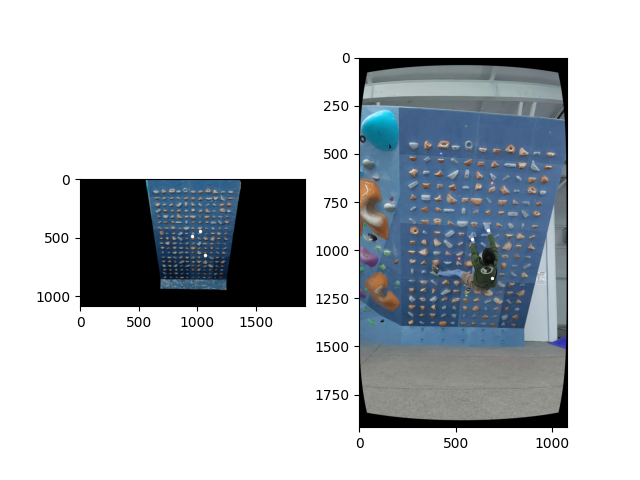

In [60]:
coords3d_notcalibrated = []
coords3d_contact = []

fig, axes = plt.subplots(1,2)
axes[0].imshow(img1)
axes[1].imshow(img2)

contacts2d_dict = contacts2d.dict_points
contacts3d_dict = contacts3d.dict_points

for part in contacts3d.dict_points.keys():
    if contacts3d_dict[part]['state'] == 1:

# for k, v in contacts2d.dict_points.items():
#     if v['state'] == 1:
#         print(k, v['coords'])
        # Projection of the point in video frame to the rendered image
        point_to_project = np.array([contacts2d_dict[part]['coords']], dtype='float32').reshape(-1, 1, 2)
        projected_point = cv2.perspectiveTransform(point_to_project, np.linalg.inv(perspective_transformation))[0]
        axes[0].scatter(*projected_point[0], c='white', s=2)
        axes[1].scatter(*point_to_project[0][0], c='white', s=2)

        print("Projected Point:", projected_point[0])
        p2d, p3d = get_pair_2d_3d(projected_point, point_to_project[0], scn, cam_obj0, K_blender)
        
        coords3d_notcalibrated.append(contacts3d_dict[part]['coords'])
        coords3d_contact.append(p3d[0])

In [61]:
def compute_transformation_matrix(A, B):
    # Center the points
    A_centered = A - np.mean(A, axis=0)
    B_centered = B - np.mean(B, axis=0)

    # Compute the covariance matrix
    H = np.dot(A_centered.T, B_centered)

    # Perform SVD
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Ensure a right-handed coordinate system
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Compute the translation
    t = np.mean(B, axis=0) - np.dot(R, np.mean(A, axis=0))

    # Create the transformation matrix
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t

    return T

In [62]:
def frame_to_timestamp(frame_number, fps_video):
    time_sec = frame_number / fps_video
    minutes = int(time_sec // 60)
    seconds = int(time_sec % 60)
    milliseconds = int((time_sec * 1000) % 1000)
    return f'{minutes:02}:{seconds:02}.{milliseconds:03}'

Update the pose 3d coords

In [63]:
# Compute the transformation from the current pose to the adjusted pose

M = compute_transformation_matrix(coords3d_notcalibrated, coords3d_contact)
pose_global_calibrated = coords_transformation(pose_global, M)

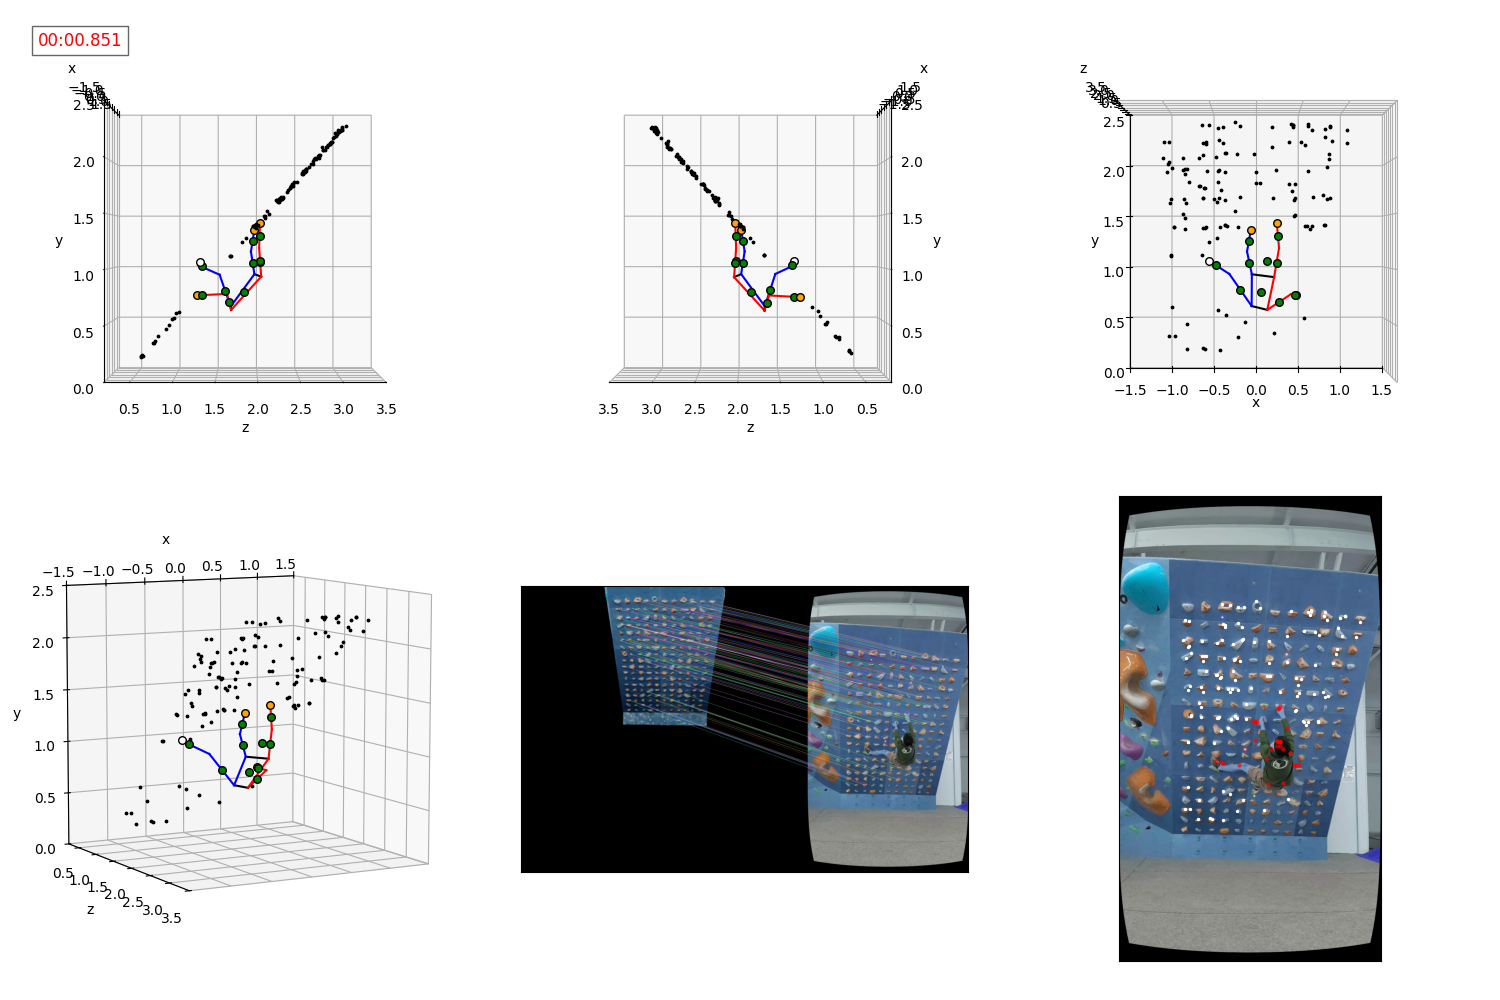

In [65]:
body = Body(frame_number, human_pose.coords2d[frame_number], pose_global_calibrated, "C:/Users/susum/Desktop/1StarChoss_trimmed.pkl")
pose2d_projection, _ = cv2.projectPoints(
    human_pose.coords3d[frame_number],
    rvec_mp2img, tvec_mp2img,
    cameradata.intrinsic_matrix,
    np.array(cameradata.distortion_coeff)
    )

holds2d_projection, _ = cv2.projectPoints(
    pts_wld,
    rvec_wall, tvec_wall,
    cameradata.intrinsic_matrix,
    np.array(cameradata.distortion_coeff)
    )

plt.ion()
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.view_init(elev=0, azim=180, roll=-90)
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.view_init(elev=0, azim=0, roll=90)
ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.view_init(elev=90, azim=-90, roll=0)
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
ax4.view_init(elev=60, azim=164, roll=-104)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)
ax3d = [ax1, ax2, ax3, ax4]
ax2d = [ax5, ax6]
plt.tight_layout()

for ax in ax3d+ax2d:
    ax.set_aspect('equal')


for ax in ax3d:
    ax.set_xlim3d(-1.5, 1.5)
    ax.set_ylim3d(0, 2.5)
    ax.set_zlim3d(0.2, 3.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    body.plot(ax, size_contact=30, size_com=30)
    for coords in pts_wld:
        x, y, z = coords
        ax.scatter(x, y, z, c='black', s=3)

for ax in ax2d:
    ax.set_xticks([])
    ax.set_yticks([])

ax5.imshow(img3)
ax6.imshow(img2)
for i in range(pose2d_projection.shape[0]):
    ax6.scatter(*pose2d_projection[i][0], s=5, c='red', alpha=0.5)

for i in range(holds2d_projection.shape[0]):
    ax6.scatter(*holds2d_projection[i][0], c='white', s=2)
ax1.text2D(0.05, 0.95, f"{frame_to_timestamp(frame_number, videodata.fps)}", transform=ax1.transAxes,
            fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.6))
plt.ioff()

# Iterate the routine through the whole video

## More work on the rendering angle optimisation for the case camera is moving ...

In [67]:
yolomodel = 'models/best.pt'
masker = Masker(yolomodel)

In [ ]:
videodata_new = VideoData("C:/Users/susum/Desktop/1StarChoss_trimmed.mp4")
videodata_copy = VideoData("C:/Users/susum/Desktop/1StarChoss_trimmed.mp4")
human_pose = videodata_copy.get_human_pose()
del videodata_copy

HumanPose initialised


In [ ]:
n_frames = videodata.total_frames - 1
fps = 20
output_path = os.path.join(
    os.path.dirname(os.path.abspath('__file__')),
    os.pardir,
    os.pardir,
    'database',
    'animation.gif'
    )

"""
Fig and ax setup
"""
plt.ioff()
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)
ax3d = [ax1, ax2, ax3, ax4]
ax2d = [ax5, ax6]

def init_axes():
    """Initialize static axis properties."""
    views = [
        dict(elev=0, azim=180, roll=-90),
        dict(elev=0, azim=0, roll=90),
        dict(elev=90, azim=-90, roll=0),
        dict(elev=60, azim=164, roll=-104)
    ]
    for ax, view in zip(ax3d, views):
        ax.view_init(**view)
        ax.set_xlim3d(-1.5, 1.5)
        ax.set_ylim3d(0, 2.5)
        ax.set_zlim3d(0.2, 3.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_aspect('equal')
    for ax in ax2d:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

init_axes()
plt.tight_layout()

"""
Animation Frame Update Function
"""

def update(frame_number):
    print(frame_number/videodata.total_frames)
    # Clear dynamic content from all axes
    for ax in ax3d + ax2d:
        ax.cla()
    init_axes()  # Reset views and labels

    """
    Actual Computation
    """

    img2 = cv2.undistort(videodata.load_frame(frame_number), cameradata.intrinsic_matrix, cameradata.distortion_coeff)
    # Colour -> Grey
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Blurred Grey Images
    img2_gray = cv2.GaussianBlur(img2_gray, (3,3), cv2.BORDER_DEFAULT)
    img1_adjust = gammaCorrection(img1_gray)
    img2_adjust = gammaCorrection(img2_gray)
    img1_ = invert(img1_adjust)
    img2_ = invert(img2_adjust)

    mask = masker.apply_mask(img2, 0.3, cls2include=[0], cls2exclude=[1, 2])
    # A-KAZE detector
    akaze = cv2.AKAZE_create()
    # Feature detection and feature vector computation
    # https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677
    kp1, des1 = akaze.detectAndCompute(img1_, None)
    kp2, des2 = akaze.detectAndCompute(img2_, mask)

    cross_check = True
    # cross_check = False

    # creating Brute-Force Matcher
    # https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
    if cross_check:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)
        matches = bf.match(des1, des2)
        # Sort them in the order of their distance.
        matches_good = sorted(matches, key = lambda x:x.distance)
    else:
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)
        # Select pairs by similarity in feature vectors
        matches_good = []
        ratio = 0.5
        while len(matches_good) < 20:
            ratio += 0.01
            matches_good = []
            for m, n in matches:
                if m.distance < ratio * n.distance:
                    matches_good.append([m])

    # Geometric Verification -> Assuming that the feature points are alighned on the same plane!
    # queryIdx: index of the descriptor in the first set
    # trainIdx: index of the descriptor in the second set

    # Rendered image
    pt1 = np.float32([kp1[m.queryIdx].pt for m in matches_good])
    # Snapshot
    pt2 = np.float32([kp2[m.trainIdx].pt for m in matches_good])

    # Compute homography using RANSAC
    # https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
    # https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html
    perspective_transformation, mask = cv2.findHomography(pt1, pt2, cv2.RANSAC, 5.0)

    matches_plane = []
    for i, m in enumerate(matches_good):
        if mask[i]:
            matches_plane.append(m)

    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches_plane, None, flags=2)

    # print('# Point on the Same Plane / # Feature Points: ', len(matches_plane)/len(matches_good))

    # Coordinates of the keypoints in reference and target images
    pt1 = np.float32([kp1[m.queryIdx].pt for m in matches_plane])
    pt2 = np.float32([kp2[m.trainIdx].pt for m in matches_plane])
    pts_img, pts_wld = get_pair_2d_3d(pt1, pt2, scn, cam_obj0, K_blender)

    rvec_wall, tvec_wall = solvePnP(pts_wld, pts_img, cameradata)

    r, theta, height = 8, 0, 1.7
    rvec_render = cam_position2rvec(theta)
    tvec_render = cam_position2tvec(r, theta, height, vector_fmt=True)
    T_wall_rendering = get_extrinsic_matrix(rvec_render, tvec_render)
    T_wall_rendering_inv = np.linalg.inv(T_wall_rendering)

    T_wall = get_extrinsic_matrix(rvec_wall, tvec_wall)
    T_wall_inv = np.linalg.inv(T_wall)

    rvec_mp2img, tvec_mp2img = mediapipe_3d2d_solvePnP(human_pose, frame_number)
    T_mp2img = get_extrinsic_matrix(rvec_mp2img, tvec_mp2img)

    pose_global = coords_transformation(human_pose.coords3d[frame_number], T_mp2img, T_wall_inv)
    body = Body(frame_number, human_pose.coords2d[frame_number], pose_global, "C:/Users/susum/Desktop/1StarChoss_trimmed.pkl")

    contacts2d = body.contact_points2d
    contacts3d = body.contact_points3d

    coords3d_notcalibrated = []
    coords3d_contact = []

    contacts2d_dict = contacts2d.dict_points
    contacts3d_dict = contacts3d.dict_points

    for part in contacts3d.dict_points.keys():
        if contacts3d_dict[part]['state'] == 1:
            # Projection of the point in video frame to the rendered image
            point_to_project = np.array([contacts2d_dict[part]['coords']], dtype='float32').reshape(-1, 1, 2)
            projected_point = cv2.perspectiveTransform(point_to_project, np.linalg.inv(perspective_transformation))[0]
            p2d, p3d = get_pair_2d_3d(projected_point, point_to_project[0], scn, cam_obj0, K_blender)
            
            coords3d_notcalibrated.append(contacts3d_dict[part]['coords'])
            coords3d_contact.append(p3d[0])
    
    M = compute_transformation_matrix(coords3d_notcalibrated, coords3d_contact)
    pose_global_calibrated = coords_transformation(pose_global, M)

    # Visualise the results
    body = Body(frame_number, human_pose.coords2d[frame_number], pose_global_calibrated, "C:/Users/susum/Desktop/1StarChoss_trimmed.pkl")
    pose2d_projection, _ = cv2.projectPoints(
        human_pose.coords3d[frame_number],
        rvec_mp2img, tvec_mp2img,
        cameradata.intrinsic_matrix,
        np.array(cameradata.distortion_coeff)
        )

    holds2d_projection, _ = cv2.projectPoints(
        pts_wld,
        rvec_wall, tvec_wall,
        cameradata.intrinsic_matrix,
        np.array(cameradata.distortion_coeff)
        )


    """
    Plots Update
    """

    for ax in ax3d:
        # body.plot(ax, size_contact=30, size_com=10)
        for coords, col in zip(body.edges3d.values(), body.edges_col.values()):
            p0, p1 = coords
            xs, ys, zs = [p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]]
            ax.plot(xs, ys, zs, c=col)
        for point in body.contact_points3d.dict_points.values():
            col = 'white'
            if point['state'] == 1:
                col = 'orange'
            x, y, z = point['coords']
            ax.scatter(x, y, z, marker='o', c=col, edgecolors='k', s=30)

        for key, val in body.dict_com3d.items():
            x, y, z = val
            ax.scatter(x, y, z, marker='o', c='green', edgecolors='k', s=10)


        for coords in pts_wld:
            x, y, z = coords
            ax.scatter(x, y, z, c='black', s=3, alpha=0.5)
    for ax in ax2d:
        ax.set_xticks([])
        ax.set_yticks([])

    ax5.imshow(img3)
    ax6.imshow(img2)
    for i in range(pose2d_projection.shape[0]):
        ax6.scatter(*pose2d_projection[i][0], s=5, c='red', alpha=0.9)

    for i in range(holds2d_projection.shape[0]):
        ax6.scatter(*holds2d_projection[i][0], c='white', s=2, alpha=0.9)

    ax1.text2D(0.05, 0.95, f'{frame_to_timestamp(frame_number, videodata.fps)}', transform=ax1.transAxes,
                fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.6))
    return []

ani = FuncAnimation(fig, update, frames=n_frames, blit=False, interval=1000/fps)
ani.save(output_path, writer='ffmpeg', dpi=200)
plt.close(fig)